<a href="https://colab.research.google.com/github/Pedrammdp/Machine-Learning-Deep-Learning-/blob/main/ISOMap%26MDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isomap & MDS

##Implmenting Isomap from scratch

### Computing the pairwise distance matrix

In [ ]:
import numpy as np
from  scipy.spatial.distance import pdist, squareform

def euclidean_distance(p1, p2):
  return np.sqrt(np.sum((p1 - p2)**2))

def compute_distance_matrix(data):
  n = data.shape[0]
  distance_matrix = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i == j:
        distance_matrix[i, j] = 0
      else:
        distance_matrix[i,j] = euclidean_distance(data[i], data[j])
  return distance_matrix

### Neighborhood Graph

In [ ]:
def k_nearest_neighbors(dist, k):

  n = dist.shape[0]

  # if j is among the k-nearest neighbors of i, otherwise infinity
  graph_dist = np.full_like(dist, np.inf)
  for i in range(n):
    sorted_indices = np.argsort(dist[i])[1:]

    neighbors_indices = sorted_indices[:k]
    for neighbor_index in neighbors_indices:
      graph_dist[i, neighbor_index] = dist[i, neighbor_index]
      # undirected graph so we need to add the reverse edge
      graph_dist[neighbor_index, i] = dist[neighbor_index, i]

    graph_dist[i,i] = 0

  return graph_dist



### Compoute Geodesic Distance


In [ ]:
# Shortest Path between all pairs of vertices

def floyd_warshall(graph_dist):
  n = graph_dist.shape[0]
  geodesic_dist = np.copy(graph_dist)

  for k in range(n):
    for i in range(n):
      for j in range(n):
        # if the path k i shorter tahn current one
        if geodesic_dist[i, k] != np.inf and \
           geodesic_dist[k, j] != np.inf:
            geodesic_dist[i,j] = min(geodesic_dist[i,j],
                                    geodesic_dist[i,k] + geodesic_dist[k,j])
  return geodesic_dist

### Multidimensional Scaling (MDS)
transforming distances to coordinates


In [ ]:
def Mds(distances_squared, n_components):
  n = distances_squared.shape[0]

  # Double Centering Matrix (J)
  H = np.eye(n) - np.ones((n,n)) / n
  # Compute Matrix B
  B = -0.5 * H @ distances_squared @ H

  # Eigenvalue Decomposition

  eigenvalues, eigenvectors = np.linalg.eigh(B)

  # Sort eigenvalues & eigenvectors
  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]

  positive_eigenvalue_indices = np.where(eigenvalues > 1e-6)[0]

  if len(positive_eigenvalue_indices) < n_components:
        print(f"Warning: Only {len(positive_eigenvalue_indices)} positive eigenvalues found, less than requested n_components={n_components}.")
        n_components = len(positive_eigenvalue_indices)

  selected_eigenvalues = eigenvalues[:n_components]
  selected_eigenvectors = eigenvectors[:, :n_components]

  embedding = selected_eigenvectors @ np.diag(np.sqrt(selected_eigenvalues))

  return embedding

### The Isomap function

In [ ]:
def isomap(distance_matrix, n_neighbors, n_components):

  pairwise_distances = distance_matrix

  neighborhood_graph = k_nearest_neighbors(pairwise_distances, n_neighbors)

  geodesic_dist = floyd_warshall(neighborhood_graph)

  if np.any(np.isinf(geodesic_dist[geodesic_dist !=0])):
        max_finite_dist = np.max(geodesic_dist[np.isfinite(geodesic_dist)])
        geodesic_dist[np.isinf(geodesic_dist)] = max_finite_dist * 2

  squared_geodesic_distances = geodesic_dist**2
  embedding = Mds(squared_geodesic_distances, n_components)

  return embedding


### Implementing on the dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Load the distances.csv file
    df_distances = pd.read_csv('distances.csv')

    # Extract city names and the distance matrix
    city_names = df_distances['Unnamed: 0'].tolist()
    distance_matrix_np = df_distances.drop(columns=['Unnamed: 0']).values

    n_neighbors_val = 5
    n_components_val = 2

    isomap_embedding_from_file = isomap(
        distance_matrix_np, n_neighbors=n_neighbors_val, n_components=n_components_val
    )

    print("\nShape of Isomap embedding:", isomap_embedding_from_file.shape)
    print("First 5 rows of Isomap embedding:\n", isomap_embedding_from_file[:5])

    # Angle for clockwise rotation by 45 degrees
    angle_degrees = -45
    angle_radians = np.deg2rad(angle_degrees)
    # 2D Rotation Matrix for clockwise rotation
    rotation_matrix = np.array([
        [np.cos(angle_radians), np.sin(angle_radians)],
         [-np.sin(angle_radians), np.cos(angle_radians)]
        ])
    # Apply the rotation to the embedding
    rotated_embedding = isomap_embedding_from_file @ rotation_matrix
    print(rotated_embedding.shape)
    print("First 5 rows of the Rotated Isomap embedding:\n", rotated_embedding[:5])
    # Visualization
    if n_components_val == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(rotated_embedding[:, 0], rotated_embedding[:, 1])
        for i, city in enumerate(city_names):
            plt.annotate(city, (rotated_embedding[i, 0], rotated_embedding[i, 1]),
                         textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)
        plt.title(f"Isomap Embedding of City Distances (k={n_neighbors_val}, {n_components_val}D)")
        plt.xlabel("Isomap Dimension 1")
        plt.ylabel("Isomap Dimension 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif n_components_val == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(rotated_embedding[:, 0], rotated_embedding[:, 1], rotated_embedding[:, 2])
        for i, city in enumerate(city_names):
            ax.text(rotated_embedding[i, 0], rotated_embedding[i, 1], rotated_embedding[i, 2],
                    city, size=8, zorder=1, color='k')
        ax.set_title(f"Isomap Embedding of City Distances (k={n_neighbors_val}, {n_components_val}D)")
        ax.set_xlabel("Isomap Dimension 1")
        ax.set_ylabel("Isomap Dimension 2")
        ax.set_zlabel("Isomap Dimension 3")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Visualization not supported for n_components={n_components_val}. "
              "Please set n_components to 2 or 3 for plotting.")

FileNotFoundError: [Errno 2] No such file or directory: 'distances.csv'

## Implementing Isomap with Scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap

df_distances = pd.read_csv('distances.csv')

# Extract city names and the distance matrix
city_names = df_distances['Unnamed: 0'].tolist()
distance_matrix_np = df_distances.drop(columns=['Unnamed: 0']).values

n_neighbors_val = 5
n_components_val = 2

print(f"Applying Isomap with scikit-learn using n_neighbors={n_neighbors_val} and n_components={n_components_val}...")

isomap_sklearn = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric='precomputed')

# Fit and transform the distance matrix to get the low-dimensional embedding
isomap_embedding_sklearn = isomap_sklearn.fit_transform(distance_matrix_np)

print("\nShape of Isomap embedding scikit-learn:", isomap_embedding_sklearn.shape)
print("First 5 rows of the Isomap embedding scikit-learn:\n", isomap_embedding_sklearn[:5])

# Angle for clockwise rotation by 45 degrees
angle_degrees = -45
angle_radians = np.deg2rad(angle_degrees)

# 2D Rotation Matrix for clockwise rotation
rotation_matrix = np.array([
    [np.cos(angle_radians), np.sin(angle_radians)],
    [-np.sin(angle_radians), np.cos(angle_radians)]
])

# Apply the rotation to the embedding
rotated_embedding = isomap_embedding_sklearn @ rotation_matrix

print(rotated_embedding.shape)
print("First 5 rows of the Rotated Isomap embedding:\n", rotated_embedding[:5])
# Visualization
if n_components_val == 2:
    plt.figure(figsize=(10, 8))
    plt.scatter(rotated_embedding[:, 0], rotated_embedding[:, 1])
    for i, city in enumerate(city_names):
        plt.annotate(city, (rotated_embedding[i, 0], rotated_embedding[i, 1]),
                     textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)
    plt.title(f"Isomap Embedding of City Distances (scikit-learn, k={n_neighbors_val}, {n_components_val}D)")
    plt.xlabel("Isomap Dimension 1")
    plt.ylabel("Isomap Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
elif n_components_val == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rotated_embedding[:, 0], rotated_embedding[:, 1], rotated_embedding[:, 2])
    for i, city in enumerate(city_names):
        ax.text(rotated_embedding[i, 0], rotated_embedding[i, 1], rotated_embedding[i, 2],
                city, size=8, zorder=1, color='k')
    ax.set_title(f"Isomap Embedding of City Distances (scikit-learn, k={n_neighbors_val}, {n_components_val}D)")
    ax.set_xlabel("Isomap Dimension 1")
    ax.set_ylabel("Isomap Dimension 2")
    ax.set_zlabel("Isomap Dimension 3")
    plt.tight_layout()
    plt.show()
else:
    print(f"Visualization not supported for n_components={n_components_val}. "
          "Please set n_components to 2 or 3 for plotting.")

FileNotFoundError: [Errno 2] No such file or directory: 'distances.csv'

# Part 2: Dimension Reduction


In [ ]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.manifold import trustworthiness

## Loading & transforming MNIST


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


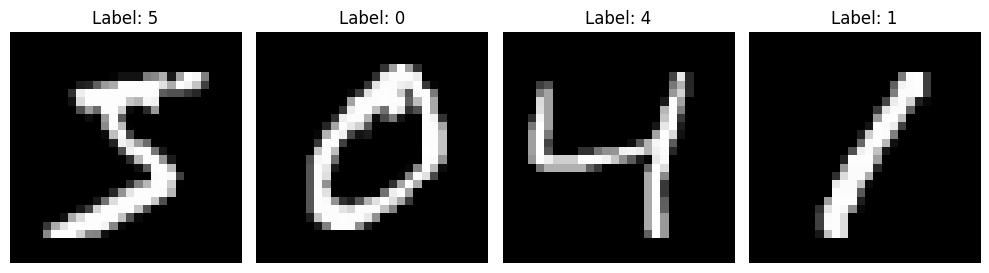

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## t-SNE

In [ ]:
n_samples = 200
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=n_samples, stratify=y_train, random_state=42)

X_subset = np.array([X_subset[i].flatten() for i in range(n_samples)])
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
X_tsne = X_tsne.fit_transform(X_subset)

trust = trustworthiness(X_subset, X_tsne, n_neighbors=5)
print(f"Trustworthiness score (TSNE): {trust:.4f}")

Trustworthiness score (TSNE): 0.9369


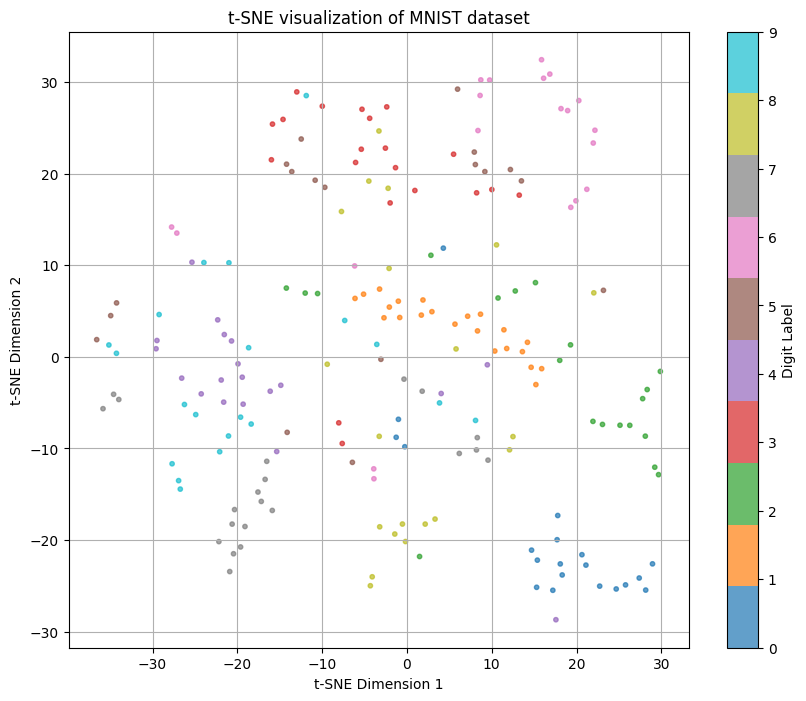

In [ ]:
plt.figure(figsize=(10, 8))
# Plotting each digit class with a different color
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('t-SNE visualization of MNIST dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

## PCA

Trustworthiness score (PCA): 0.7344


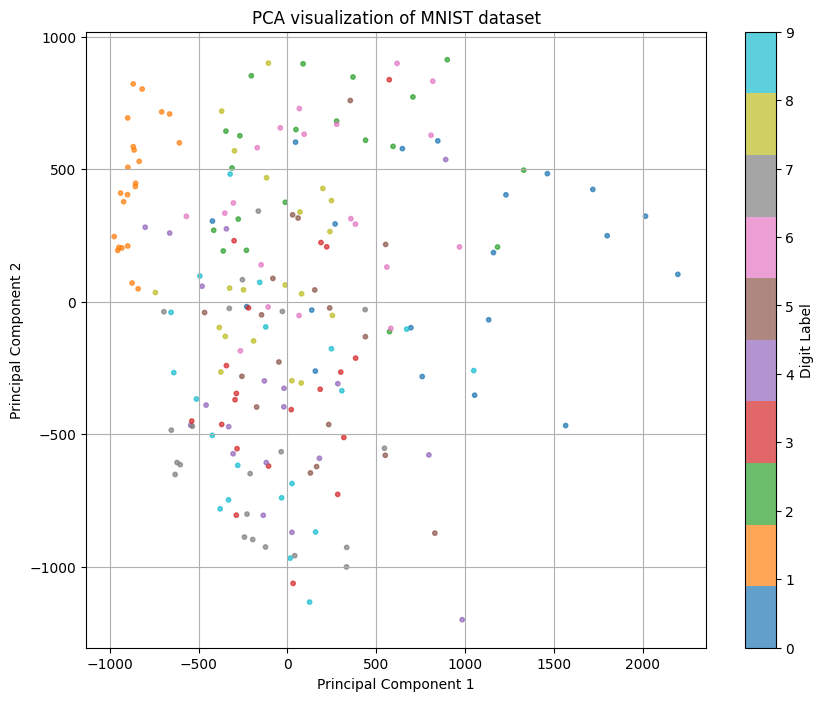

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_subset)

trust = trustworthiness(X_subset, X_pca, n_neighbors=5)
print(f"Trustworthiness score (PCA): {trust:.4f}")

plt.figure(figsize=(10, 8))
# Plotting each digit class with a different color
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('PCA visualization of MNIST dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
trust = trustworthiness(X_pca, X_tsne, n_neighbors=5)
print(f"Trustworthiness score (PCA and t-SNE): {trust:.4f}")

Trustworthiness score (PCA and t-SNE): 0.8478


## Perplexity & KL Divergence

  Running t-SNE with perplexity = 5...
    Finished. KL Divergence: 0.8485
  Running t-SNE with perplexity = 10...
    Finished. KL Divergence: 0.9639
  Running t-SNE with perplexity = 20...
    Finished. KL Divergence: 0.7679
  Running t-SNE with perplexity = 30...
    Finished. KL Divergence: 0.6778
  Running t-SNE with perplexity = 50...
    Finished. KL Divergence: 0.4894
  Running t-SNE with perplexity = 80...
    Finished. KL Divergence: 0.3969
  Running t-SNE with perplexity = 100...
    Finished. KL Divergence: 0.2816


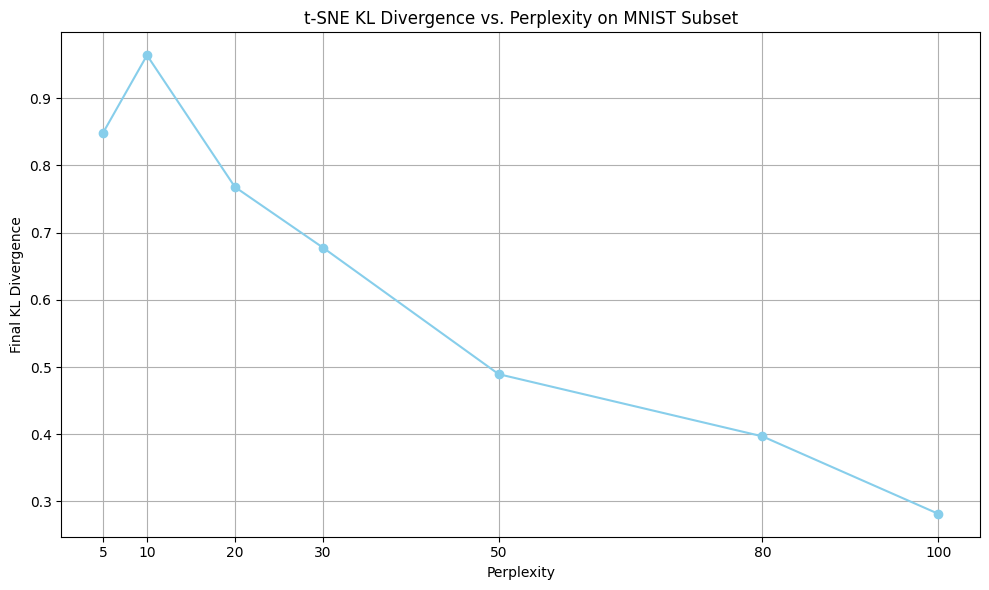

In [ ]:
perplexities = [5, 10, 20, 30, 50, 80, 100]
kl_divergences = []


for perplexity in perplexities:
    print(f"  Running t-SNE with perplexity = {perplexity}...")

    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_subset)

    kl_divergences.append(tsne.kl_divergence_)

    print(f"    Finished. KL Divergence: {tsne.kl_divergence_:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(perplexities, kl_divergences, marker='o', linestyle='-', color='skyblue')
plt.title('t-SNE KL Divergence vs. Perplexity on MNIST Subset')
plt.xlabel('Perplexity')
plt.ylabel('Final KL Divergence')
plt.grid(True)
plt.xticks(perplexities)
plt.tight_layout()
plt.show()